In [7]:
import cv2
import numpy as np
from scipy.spatial.transform import Rotation as R_scipy  # Rename to avoid conflict
import matplotlib.pyplot as plt

In [3]:
# Open the video file
video_path = 'video/FAA investigating after footage emerged of drone flying above aircraft on approach to Las Vegas.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video was opened successfully
if not cap.isOpened():
    raise ValueError("Could not open the video file. Check the path.")

# Loop through the video and extract frames
frame_count = 0
while True:
    # Read the next frame
    ret, frame = cap.read() # if false break

    # If the frame was not read successfully, break the loop
    if not ret:
        break

    # Save the frame as an image file
    output_path = f'video/frame_{frame_count:04d}.jpg'  # Format: frame_0000.jpg, frame_0001.jpg, etc.
    cv2.imwrite(output_path, frame)

    # Increment frame counter
    frame_count += 1

# Release the video capture object
cap.release()
print(f"Extracted {frame_count} frames.")


Extracted 810 frames.


Tracked 408 keypoints successfully.


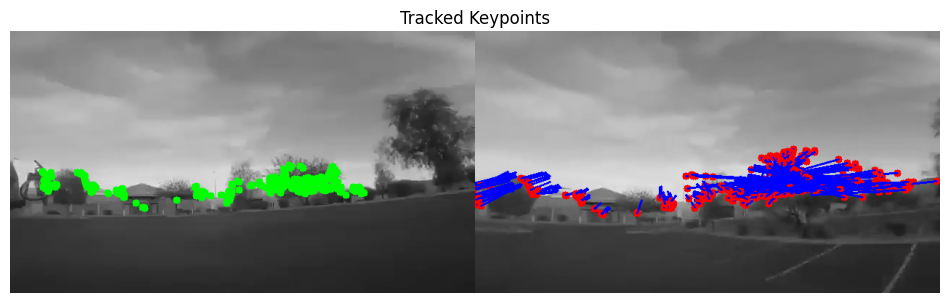

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the initial and next frames
initial_frame = cv2.imread('video/frame_0000.jpg', cv2.IMREAD_GRAYSCALE)
next_frame = cv2.imread('video/frame_0015.jpg', cv2.IMREAD_GRAYSCALE)

# Check if the images were loaded successfully
if initial_frame is None or next_frame is None:
    raise ValueError("Could not load one or both frames. Check the file paths.")

# Initialize feature detector (e.g., ORB)
detector = cv2.ORB_create()

# Detect keypoints in the initial frame
keypoints_prev, descriptors_prev = detector.detectAndCompute(initial_frame, None)

# Convert keypoints to a NumPy array of coordinates
keypoints_prev_pts = np.array([kp.pt for kp in keypoints_prev], dtype=np.float32).reshape(-1, 1, 2)

# Track keypoints in the next frame using optical flow
keypoints_next_pts, status, _ = cv2.calcOpticalFlowPyrLK(initial_frame, next_frame, keypoints_prev_pts, None)

# Check if tracking was successful
if keypoints_next_pts is None:
    raise ValueError("Optical flow tracking failed.")

# Filter keypoints based on status
keypoints_next_pts = keypoints_next_pts[status == 1]
keypoints_prev_pts = keypoints_prev_pts[status == 1]

print(f"Tracked {len(keypoints_next_pts)} keypoints successfully.")

# Convert frames to color for visualization
initial_frame_color = cv2.cvtColor(initial_frame, cv2.COLOR_GRAY2BGR)
next_frame_color = cv2.cvtColor(next_frame, cv2.COLOR_GRAY2BGR)

# Draw the tracked keypoints and motion vectors
for i, (prev_pt, next_pt) in enumerate(zip(keypoints_prev_pts, keypoints_next_pts)):
    x1, y1 = prev_pt.ravel().astype(int)
    x2, y2 = next_pt.ravel().astype(int)

    # Draw a circle at the keypoint location in the initial frame
    cv2.circle(initial_frame_color, (x1, y1), 5, (0, 255, 0), -1)

    # Draw a circle at the tracked keypoint location in the next frame
    cv2.circle(next_frame_color, (x2, y2), 5, (0, 0, 255), -1)

    # Draw a line connecting the keypoints between the two frames
    cv2.line(next_frame_color, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Combine the two frames side by side for visualization
combined_frame = np.hstack((initial_frame_color, next_frame_color))

# Convert BGR (OpenCV default) to RGB (matplotlib default)
combined_frame_rgb = cv2.cvtColor(combined_frame, cv2.COLOR_BGR2RGB)

# Display the result using matplotlib
plt.figure(figsize=(12, 6))
plt.imshow(combined_frame_rgb)
plt.axis('off')  # Hide axes
plt.title("Tracked Keypoints")
plt.show()

In [8]:
# Camera intrinsic parameters (example values, replace with your camera's parameters)
focal_length = 1.0  # Focal length (normalized)
principal_point = (0, 0)  # Principal point (normalized)

# Compute the Essential Matrix
E, mask = cv2.findEssentialMat(
    keypoints_prev_pts, keypoints_next_pts,
    focal=focal_length, pp=principal_point,
    method=cv2.RANSAC, prob=0.999, threshold=1.0
)

# Recover relative pose (rotation and translation)
_, R, t, _ = cv2.recoverPose(E, keypoints_prev_pts, keypoints_next_pts, focal=focal_length, pp=principal_point)

# Convert rotation matrix to quaternion
rotation = R_scipy.from_matrix(R)  # Use the renamed import
quaternion = rotation.as_quat()  # Returns [x, y, z, w]

print("Rotation Matrix (R):")
print(R)
print("\nTranslation Vector (t):")
print(t)
print("\nQuaternion (x, y, z, w):")
print(quaternion)


Rotation Matrix (R):
[[ 0.06884145  0.99761618  0.00477614]
 [-0.9976176   0.06886142 -0.00415083]
 [-0.00446983 -0.00447901  0.99997998]]

Translation Vector (t):
[[-0.24801143]
 [ 0.96874684]
 [ 0.00446044]]

Quaternion (x, y, z, w):
[-1.12231287e-04  3.16191948e-03 -6.82326370e-01  7.31040843e-01]


In [10]:
# Initialize global pose
global_position = np.zeros(3)  # [x, y, z]
global_rotation = np.eye(3)    # Identity matrix

# Update global pose
global_position += global_rotation @ t.flatten()
global_rotation = R @ global_rotation

print(global_position)
print(global_rotation)

[-0.24801143  0.96874684  0.00446044]
[[ 0.06884145  0.99761618  0.00477614]
 [-0.9976176   0.06886142 -0.00415083]
 [-0.00446983 -0.00447901  0.99997998]]
